---
title: "Decision Trees"
format:
  html:
    page-layout: full
    code-fold: show
    code-copy: true
    code-tools: true
    code-overflow: wrap
---

In [50]:
library(tidyverse)
library(ggplot2)
library(quantmod)
library(tidyquant)
library(plotly)
library(gridExtra)
library(tree)
library(rpart)
library(rpart.plot)
library(randomForest)

## Overview

Health insurance in the United States is always a problem governments and communities face. Compared to other countries, the U.S. does not have the flexibility and accessibility of the health care system for all citizens. President Obama took this community challenge seriously and passed two laws to make a change in the healthcare system.

The Affordable Care Act (ACA) is the name for the comprehensive health care reform law and its amendments which addresses health insurance coverage, health care costs, and preventive care, also known as Obama care. Two laws significantly affect American health insurance: The Patient Protection and Affordable Care Act. Both laws are passed by President Barack Obama on March 23, 2010, and were amended by the Health Care and Education Reconciliation Act on March 30, 2010.

In this section, I am going to use decision tree such as regression model and random forest model to focus background of Obama care and Medicaid health insurance changes.

## Data Characteristics

The data are draw from Kaggle. There are \(14\) total variables and \(2\) categorical data sets. A data set consist of \(51\) observations (\(50\) states with Washington D.C).

Uninsured_Rate_2010 - Uninsured rate in 2010

Uninsured_Rate_2015 - Uninsured rate in 2015

Uninsured_Rate_Ch_2010_2015 - Uninsured rate change between 2010 and 2015

Health_Ins_Cov_Ch_2010_2015 - Health insurance concave change between 2010 and 2015

Medicaid_Enroll_2013 - Medicaid enrollment (2013)

Medicaid_Enroll_2016 - Medicaid enrollment (2016)

Medicaid_Enroll_Ch_2013_2016 - Medicaid enrollment change between 2013 and 2016

Medicare_Enroll_2016 - Medicaid enrollment updated version (2016)



In [32]:
aca <- read.csv("cleaned_data/cleaned_states.csv", stringsAsFactors = FALSE, na = c(".", ".."))


colnames(aca) <- c("State", 
                   "Uninsured_Rate_2010", 
                   "Uninsured_Rate_2015",
                   "Uninsured_Rate_Ch_2010_2015", 
                   "Health_Ins_Cov_Ch_2010_2015",
                   "Medicaid_Enroll_2013", 
                   "Medicaid_Enroll_2016",
                   "Medicaid_Enroll_Ch_2013_2016", 
                   "Medicare_Enroll_2016")



State <- as.factor(aca$State)
UnIns2010 <- aca$Uninsured_Rate_2010
UnIns2015 <- aca$Uninsured_Rate_2015
aca$Uninsured_Rate_Ch_2010_2015 <- aca$Uninsured_Rate_2015 - aca$Uninsured_Rate_2010
UnInsRateChange <- aca$Uninsured_Rate_Ch_2010_2015
HlthInscovg <- aca$Health_Ins_Cov_Ch_2010_2015
MediEnroll2013 <- aca$Medicaid_Enroll_2013
MediEnroll2016 <- aca$Medicaid_Enroll_2016
MediChange <- aca$Medicaid_Enroll_Ch_2013_2016

#create a summary of US
aca_state <- aca[!aca$State == "United States", ]
aca_us <- aca[aca$State == "United States", ]

aca_state$State <- factor(aca_state$State)
aca_us$State <- factor(aca_us$State)


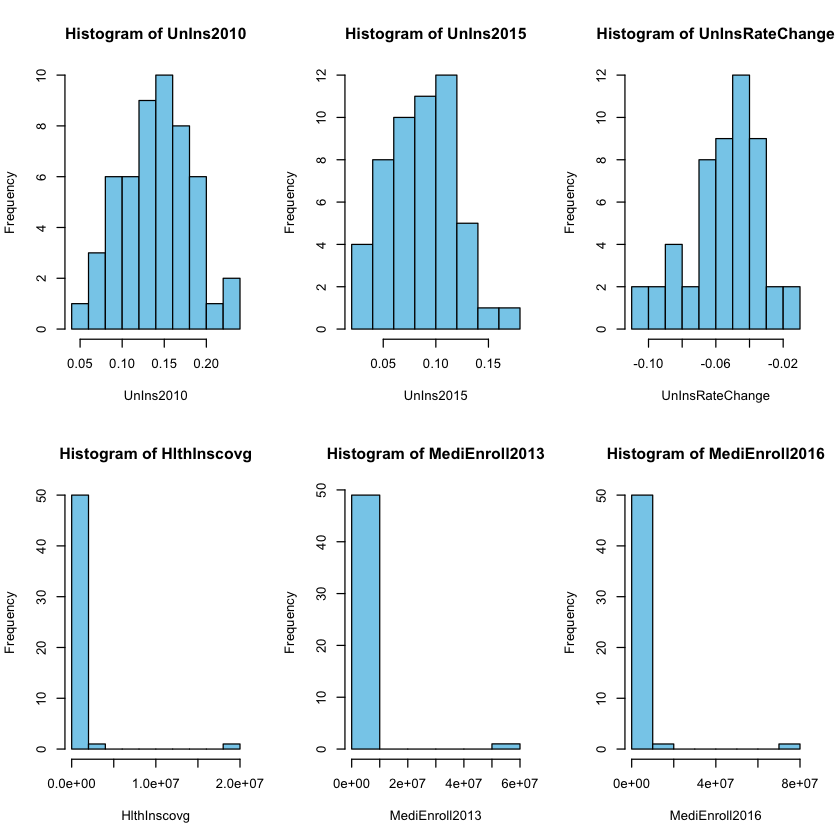

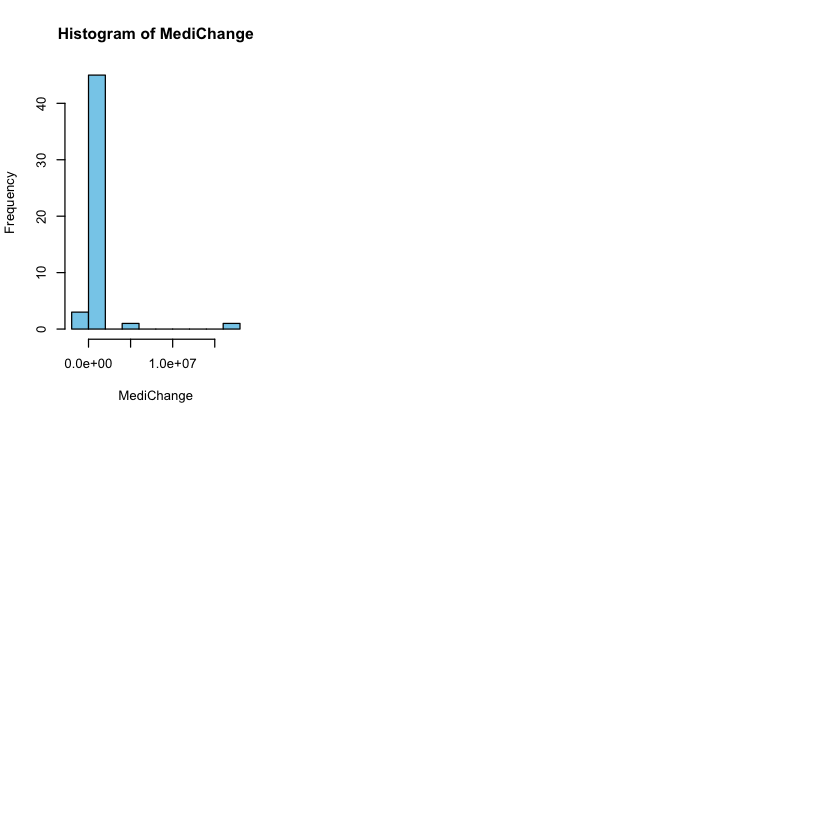

In [35]:
par(mfrow=c(2,3))
hist (UnIns2010, col="sky blue") 
hist (UnIns2015, col="sky blue")
hist (UnInsRateChange, col="sky blue")
hist (HlthInscovg, col="sky blue") 
hist (MediEnroll2013, col="sky blue") 
hist (MediEnroll2016, col="sky blue") 
hist (MediChange, col="sky blue")

## Visualize Data 

This is a new state vector that’s ordered by Uninsured Rate Change for better plotting. The blue line are describing the average of all states, the top state being the least amount of change and the bottom state being the most amount of change. We noticed that more population in states reflects the changes.

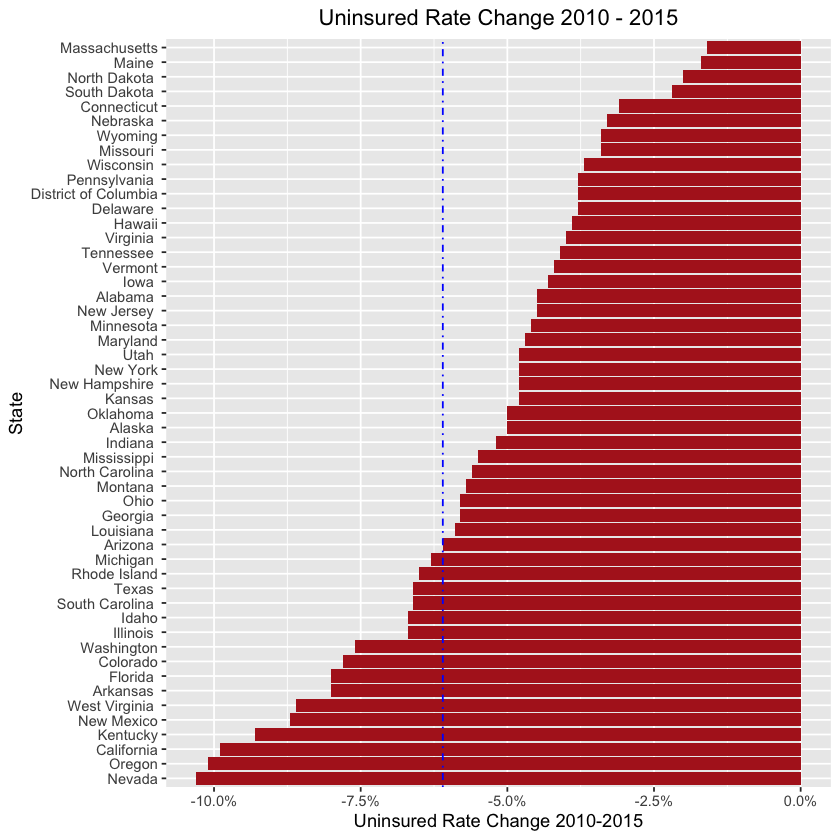

In [38]:
aca_state$State2 <- factor(aca_state$State, levels =aca_state[order(aca_state$Uninsured_Rate_Ch_2010_2015), "State"])
ggplot(aca_state, aes(State2, Uninsured_Rate_Ch_2010_2015)) + 
  geom_bar(stat="identity", fill = "firebrick") +
  scale_y_continuous(labels = scales::percent) +
  coord_flip() +
  ggtitle("Uninsured Rate Change 2010 - 2015") +
  theme(plot.title = element_text(hjust = 0.5)) +
  xlab("State") +
  ylab("Uninsured Rate Change 2010-2015") + 
  geom_hline(yintercept = aca_us$Uninsured_Rate_Ch_2010_2015, color = "blue", linetype = "dotdash")

This is a summary of a Medicaid expansion that is showing true and false by each state. The blue line is the average Medicaid enrollment change. Based on the bar graph, California had the highest expansion in Medicaid program coverage followed by New York and Washington.

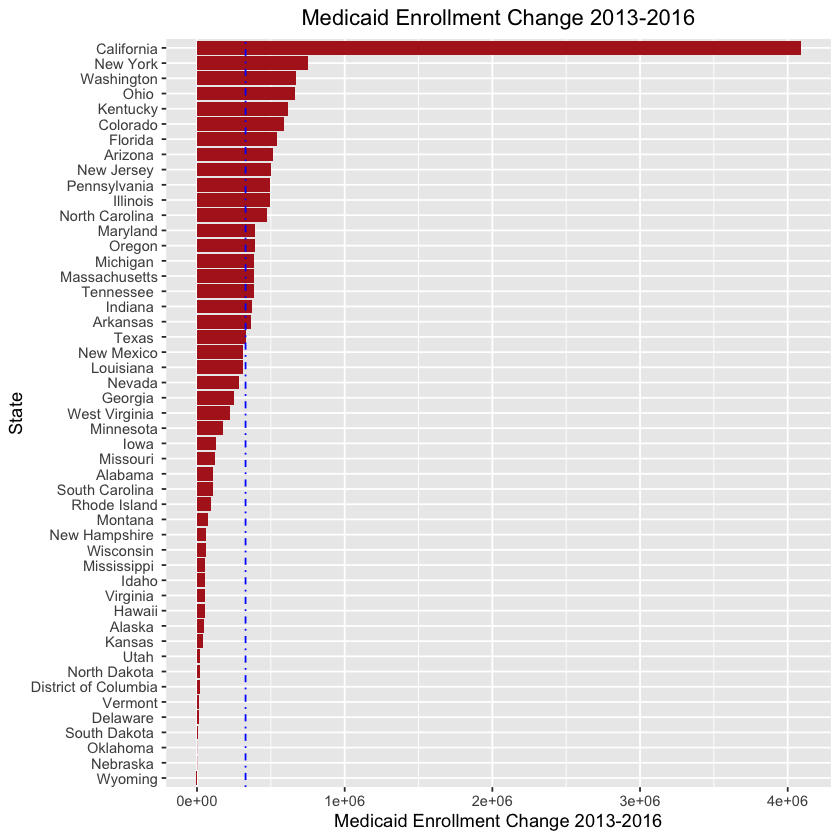

In [41]:
aca_state2 <- aca_state[complete.cases(aca_state), ] 

aca_state2$State2 <- factor(aca_state2$State, levels =aca_state2[order(aca_state2$Medicaid_Enroll_Ch_2013_2016), "State"])
ggplot(aca_state2, aes(State2, Medicaid_Enroll_Ch_2013_2016)) + 
  geom_bar(stat="identity", fill = "firebrick") +
  coord_flip() +
  ggtitle("Medicaid Enrollment Change 2013-2016") +
  theme(plot.title = element_text(hjust = 0.5)) +
  xlab("State") +
  ylab("Medicaid Enrollment Change 2013-2016") +
  geom_hline(yintercept = mean(aca_state2$Medicaid_Enroll_Ch_2013_2016), color = "blue", linetype = "dotdash") 

## Regression Model

**Simple Linear Regression**

Before performing the simple linear regression, we want to check if the model good for running the regression. To do that, we want to see if the scatter plots are fair and unbiased.

**Decision Tree**

A regression tree is one of the tree-based methods that partition the predictor space into multiple regions. Predictor space is the p-dimensional collective range of the explanatory variables and predictions are decided based on which region the observation belongs to. The tree includes internal and terminal nodes.

To build a regression tree, there are five steps to follow. First, if there are \(p\) predictors in explanatory variables, reorder them from smallest to largest then find the midpoints. Second, for the \(j\) predictor and one of the cutting points we can define as \(R_1(j,s)=(x|x_j < s)\) and \(R_2(j,s)=(x|x_j \geq s)\) . For each pair of \(j\) and \(s\) we can compute \(SE_j\) and pairs with minimum \(SE_j\) is the internal node. Third, use the smallest \(SE_j\) as the next separating. Fourth, repeat steps two and three until all regions had no more than five observation points. Lastly, for each sub region \(R\), we use \(\hat{Y}_R\) s as the prediction value of the response variable.

In some cases, there may be an output of recursive binary splitting. If regions are complex and over fitted, we may use the tree pruning method to reduce the bias in the tree. Using the cross-validation mean squared error(MSE) of training and testing data to find minimum cross-validation error which is the tree size that occurred.

Keep in mind that the tree-based method has advantages and disadvantages. Since it is easy to interpret, and visually explain, has no dummy variables, and is similar to human decision-making, there is no robustness, less accuracy than other statistical methods, and less flexibility.



**Scatter Plots**

First scatter plot below are showing the change in Medicaid enrollment from 2013 to 2016 after ACA was passed by President Obama known as ObamaCare. There is one large outlier that exists in the plot, this is the state of California. The population and poverty rate in California reflect the scatter plot and there is a significant huge impact on the Medicaid system in California. We want to remove California to perform better simple linear regression using the response variable y = aca.

Second scatter plot below is without California state. Plots are fairer than the last scatter plot and now we can perform the simple linear regression using the response variable as the uninsured rate change between 2010 and 2015 and the explanatory variable as Medicaid enrollment change between 2013 and 2016.


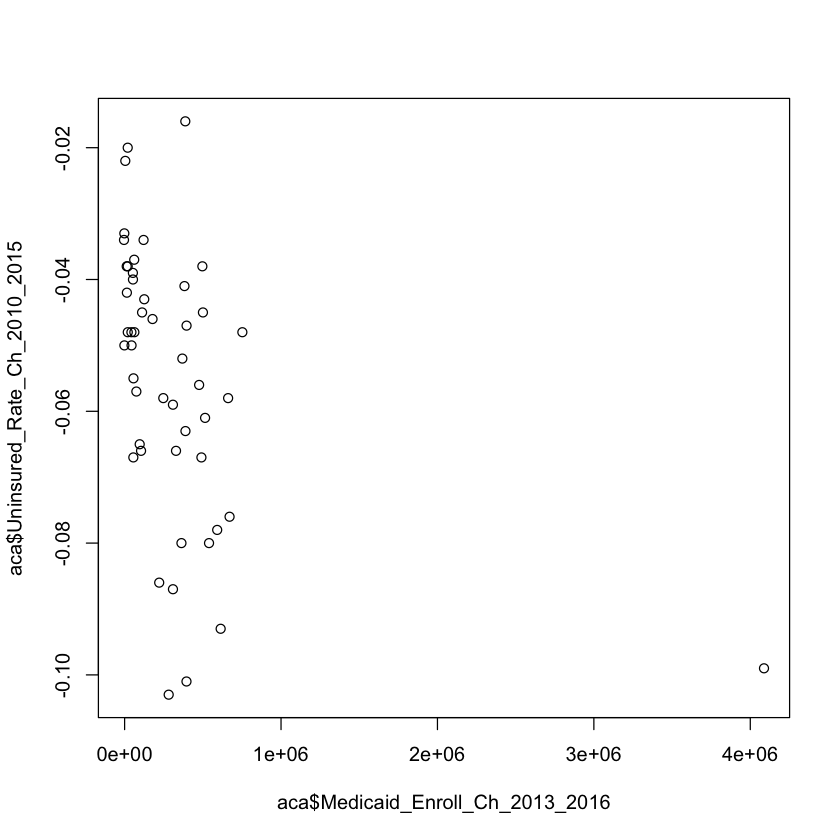

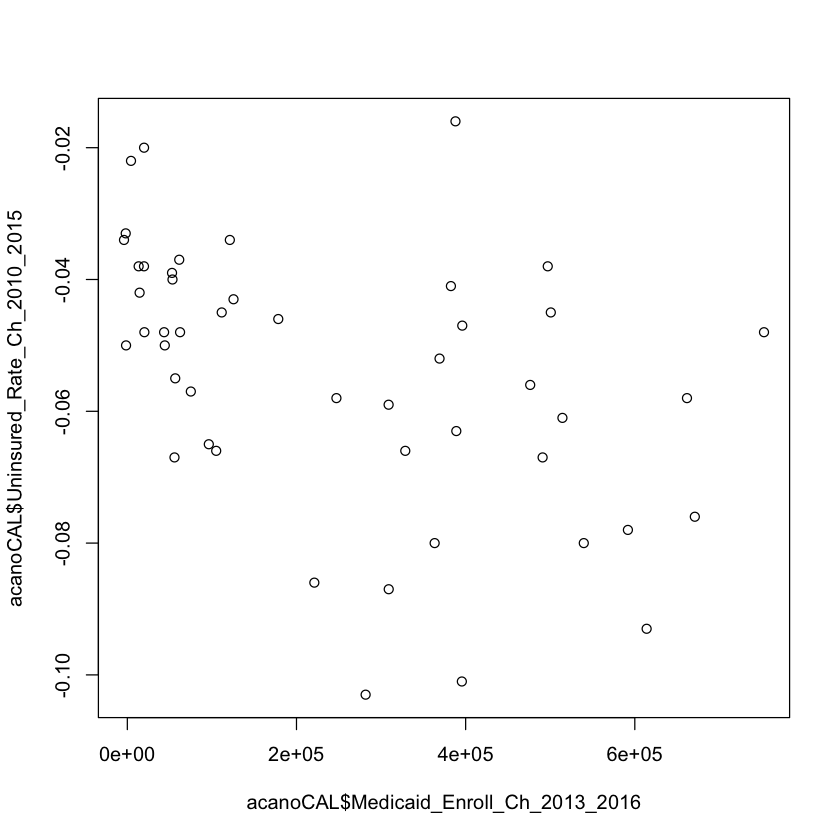

In [90]:
aca<-aca[1:51,]
plot(aca$Medicaid_Enroll_Ch_2013_2016, aca$Uninsured_Rate_Ch_2010_2015)

acanoCAL<-aca[c(1:4,6:51),]

plot(acanoCAL$Medicaid_Enroll_Ch_2013_2016, acanoCAL$Uninsured_Rate_Ch_2010_2015)

In [72]:
#Simple Linear Regression and Summary without California state
mod <- lm (Uninsured_Rate_Ch_2010_2015 ~ Medicaid_Enroll_Ch_2013_2016, data=acanoCAL)

summary(mod)

#The 95% Confidence Interval for coefficients
confint(mod,level=0.95)


Call:
lm(formula = Uninsured_Rate_Ch_2010_2015 ~ Medicaid_Enroll_Ch_2013_2016, 
    data = acanoCAL)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.047078 -0.008489  0.001183  0.010197  0.044174 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -4.464e-02  3.951e-03 -11.300 7.24e-15 ***
Medicaid_Enroll_Ch_2013_2016 -4.003e-08  1.184e-08  -3.382  0.00148 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0181 on 46 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1991,	Adjusted R-squared:  0.1817 
F-statistic: 11.44 on 1 and 46 DF,  p-value: 0.001479


,2.5 %,97.5 %
(Intercept),-5.259684e-02,-3.669208e-02
Medicaid_Enroll_Ch_2013_2016,-6.385318e-08,-1.620131e-08


Based on the R output, the prediction formula is \[\hat{y}=-4.464e^{-02}-4.003e^{-08}x\] where \(x\) is the number of Medicaid enrollment changes between 2013 and 2016.

For every number of Medicaid enrollment increase in change, it’s predicted uninsured rate change decreases by \(4.003e^{-08}\).

P-value is 0.001479, which is less than 0.05. Therefore, there is enough evidence to conclude that the simple linear regression model of uninsured rate change between 2010 and 2015 and Medicaid enrollment change between 2013 and 2016 are statistically significant.

R-squared is not the greatest number. It is only 19.91% of the variability in the ACA can be explained by the simple linear regression model of uninsured rate change between 2010 and 2015 and Medicaid enrollment change between 2013 and 2016. Adjusted R-squared is lower than R-squared which does not support the best model for this case.

## Confidence Interval and Prediction Interval

Confidence Interval:

We are 95% confident that the new law ACA health care system effect the uninsured rate change between 2010 and 2015 are between -5.259684e-02 and -3.669208e-02.

We are 95% confident that the new law ACA health care system effect the Medicaid enrollment change between 2013 and 2016 are between -6.385318e-08 and -1.620131e-08.

In [69]:
testIndex<-sample(1:50,5)

x_0 <-data.frame(Medicaid_Enroll_Ch_2013_2016=c(acanoCAL[testIndex,]$Medicaid_Enroll_Ch_2013_2016))

PREDICTRESULT <- predict(mod,newdata=x_0,interval="confidence")

cbind(acanoCAL[testIndex,]$Uninsured_Rate_Ch_2010_2015, PREDICTRESULT)

,,fit,lwr,upr
1,-0.037,-0.04710078,-0.05402417,-0.04017739
2,-0.040,-0.04678140,-0.05382993,-0.03973287
3,-0.103,-0.05592166,-0.06123292,-0.05061040
4,-0.041,-0.05995825,-0.06608789,-0.05382860
5,-0.020,-0.04543632,-0.05304150,-0.03783115


Prediction Intervals:

We are predicting five states of the confidence interval in changes using the combined method.

From the result, we noticed that the most of prediction intervals are similar to each other and there are no significant differences.

In [45]:
par(mfrow=c(1,1))

## Regression Tree

First, we are going to fit the model for regression tree.

In [91]:
tree.insurance <- tree(Uninsured_Rate_Ch_2010_2015 ~ Medicaid_Enroll_Ch_2013_2016 , data=acanoCAL)
summary(tree.insurance)


Regression tree:
tree(formula = Uninsured_Rate_Ch_2010_2015 ~ Medicaid_Enroll_Ch_2013_2016, 
    data = acanoCAL)
Number of terminal nodes:  5 
Residual mean deviance:  0.0002275 = 0.009784 / 43 
Distribution of residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.0476400 -0.0077710  0.0009375  0.0000000  0.0104400  0.0373600 

Two plots are shown below: simple regression tree and cross-validation

A tree is use only one variable of Medicaid change and the terminal nodes are five. We can say that if Medicaid enrollment is less than 199785 and 19968 in 2013-2016, the uninsured rate change is -0.03463, which means decreasing by 3.463%.

Cross-validation(cv) is showing the best terminal numbers and there are only 4 plots in a graph. The “elbow” of the graph is the best terminal node and it is located at 2. Now we are going to run the prune tree with 2 terminal nodes.

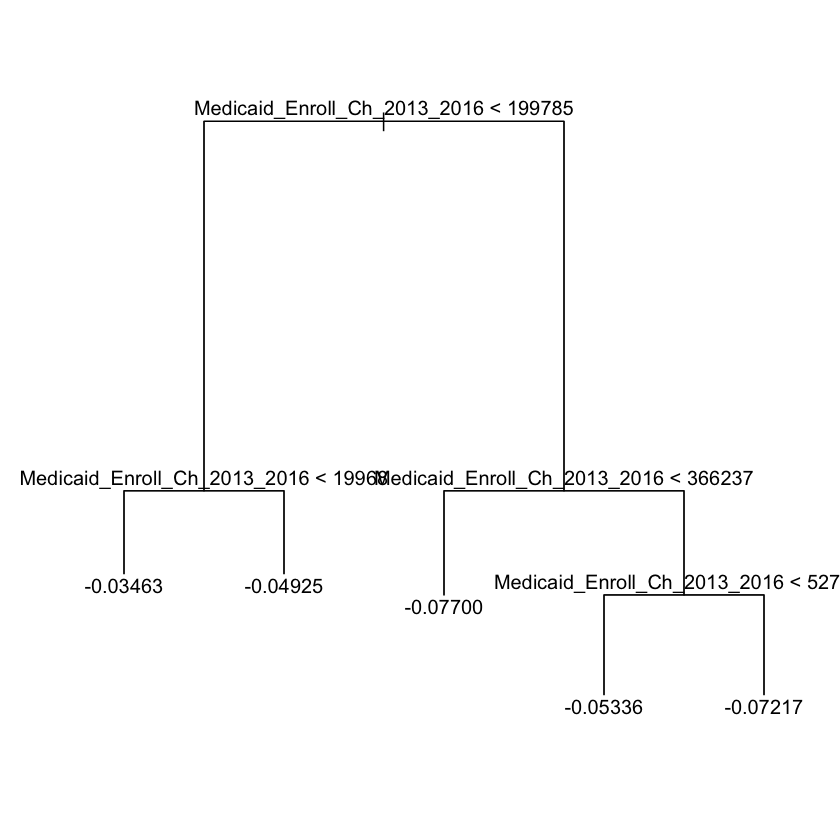

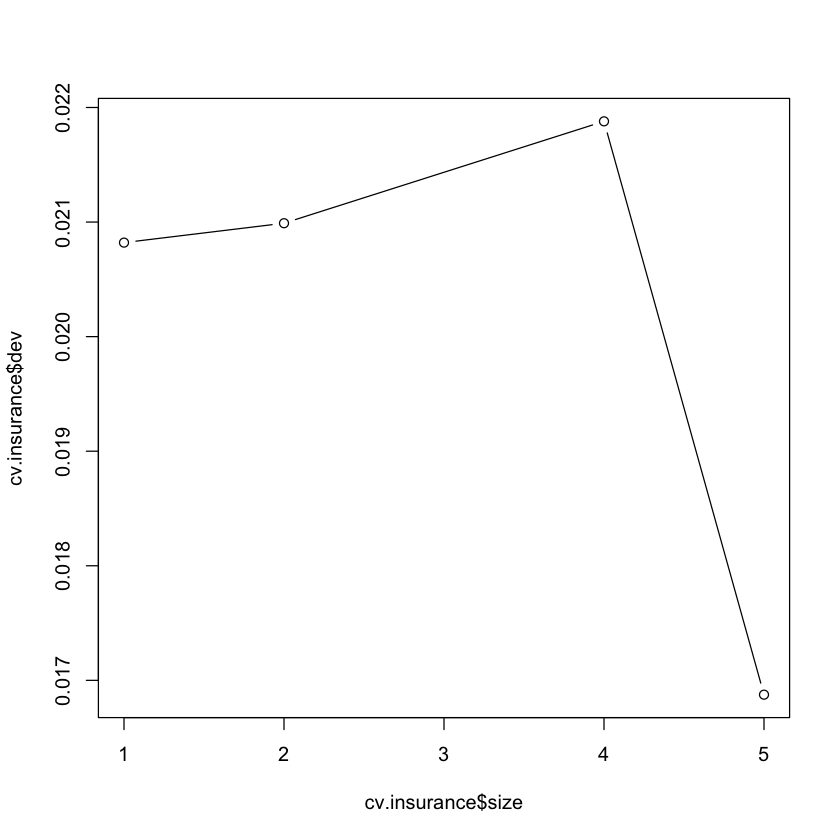

In [74]:
plot(tree.insurance)
text(tree.insurance)

cv.insurance <- cv.tree(tree.insurance)
plot (cv.insurance$size, cv.insurance$dev, type="b")

However a tree had 5 terminal nodes originally and 2 terminal nodes were recommended after running the regression tree, it would not be ideal to prune the tree. A tree is not complex enough to prune it. The scatter plot of the prune tree is also not equally spread due to the small number of plots.


Regression tree:
snip.tree(tree = tree.insurance, nodes = 2:3)
Number of terminal nodes:  2 
Residual mean deviance:  0.0002985 = 0.01373 / 46 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.038040 -0.011440  0.001667  0.000000  0.009313  0.048960 

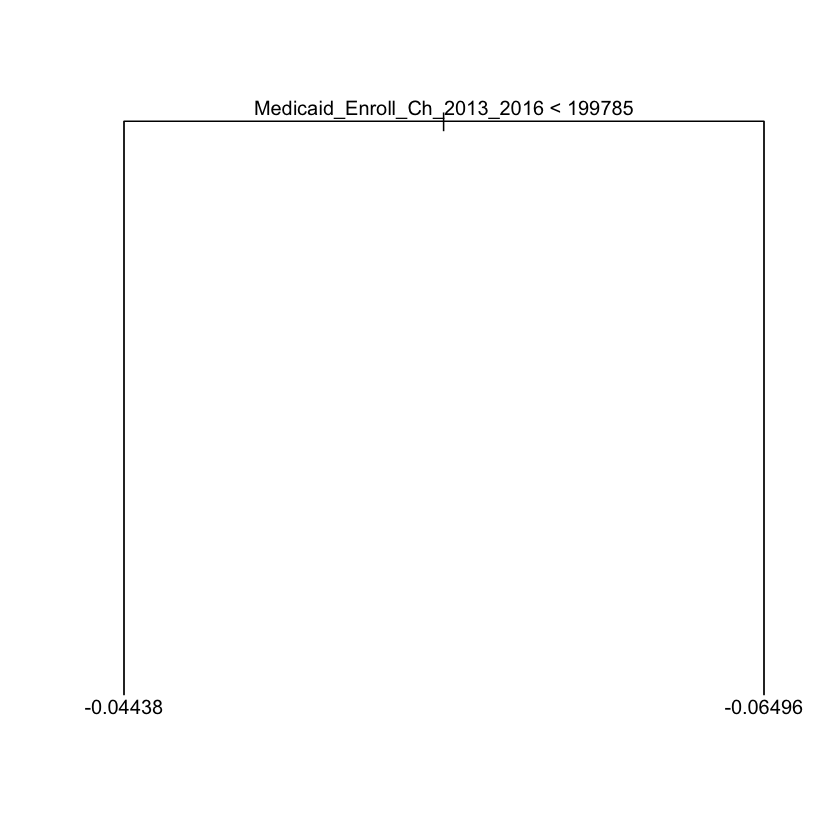

In [21]:
prune.insurance <- prune.tree(tree.insurance, best=2)
summary(prune.insurance)

plot(prune.insurance)
text(prune.insurance, pretty=0)

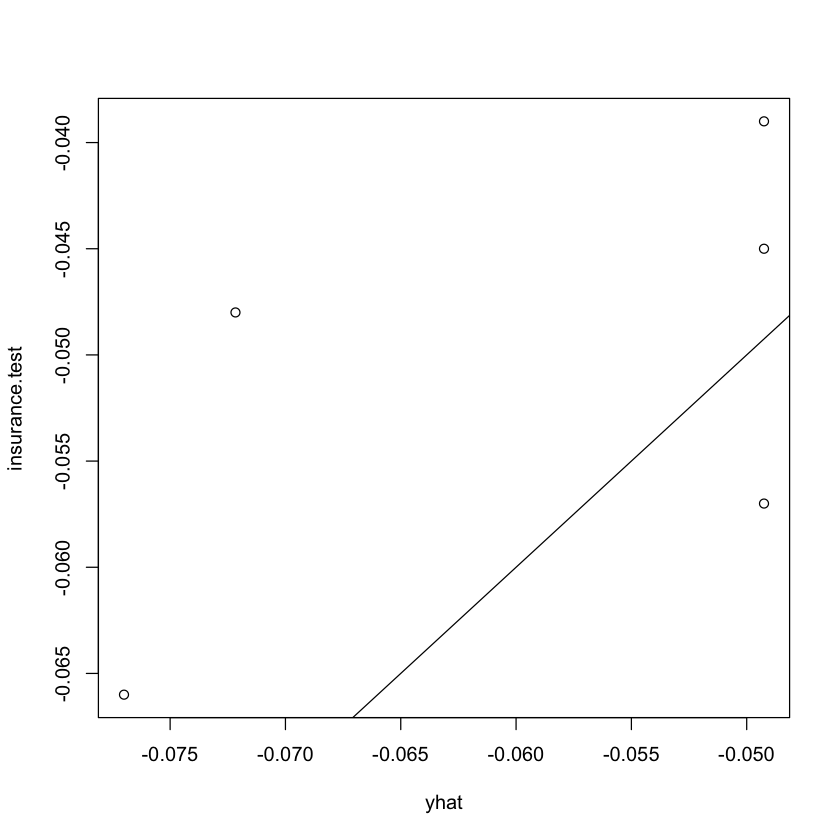

In [46]:
yhat <- predict(tree.insurance, newdata=x_0)

insurance.test <- acanoCAL[testIndex,]$Uninsured_Rate_Ch_2010_2015

plot(yhat, insurance.test)
abline(0,1)

In [76]:
mean((yhat-insurance.test)^2)

[1] 0.0001776431

## Advanced Methods - Random Forest

Next, let's implement an advanced decision tree algorithm, specifically a Random Forest, and conduct a comparative analysis with a basic regression tree model. This comparison will involve assessing both models in terms of their predictive accuracy, ability to handle overfitting, and overall performance with our dataset. The Random Forest, known for its robustness due to ensemble learning, will be contrasted against the regression tree's simpler, more interpretable structure. By evaluating key metrics such as Mean Squared Error (MSE), R-squared values, and perhaps a cross-validation score, we can gain insights into the strengths and limitations of each approach in the context of our specific data analysis goals.

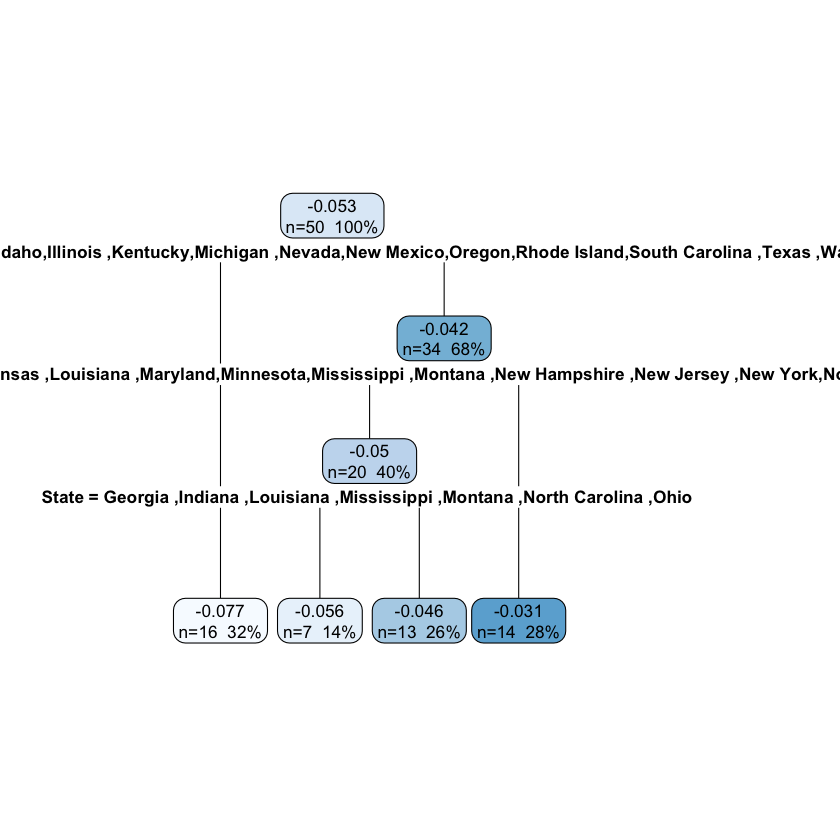

In [86]:
#fit and plot
sketch_model <- rpart(Uninsured_Rate_Ch_2010_2015 ~ ., data = acanoCAL, method = "anova")

rpart.plot(sketch_model, extra = 101)

In [88]:
acanoCAL[is.na(acanoCAL)] <- 0


train_indices <- sample(1:nrow(acanoCAL), 0.7*nrow(acanoCAL))
train_data <- acanoCAL[train_indices, ]
test_data <- acanoCAL[-train_indices, ]

lm <- tree(Uninsured_Rate_Ch_2010_2015 ~ ., data=acanoCAL)
summary(lm)

tree_predictions <- predict(lm, test_data)
R2_test <- cor(test_data$Uninsured_Rate_Ch_2010_2015, tree_predictions)^2
cat("R^2 on the test set:", R2_test)

Warning message in tree(Uninsured_Rate_Ch_2010_2015 ~ ., data = acanoCAL):
“NAs introduced by coercion”



Regression tree:
tree(formula = Uninsured_Rate_Ch_2010_2015 ~ ., data = acanoCAL)
Variables actually used in tree construction:
[1] "Uninsured_Rate_2010"          "Medicaid_Enroll_Ch_2013_2016"
[3] "Medicaid_Enroll_2013"         "Medicaid_Enroll_2016"        
Number of terminal nodes:  8 
Residual mean deviance:  8.862e-05 = 0.003722 / 42 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.015220 -0.006950 -0.001187  0.000000  0.004512  0.020500 

Warning message in pred1.tree(object, tree.matrix(newdata)):
“NAs introduced by coercion”


R^2 on the test set: 0.8760694

In [89]:
rf_model <- randomForest(Uninsured_Rate_Ch_2010_2015 ~ ., data = train_data)
summary(rf_model)

rf_predictions <- predict(rf_model, test_data)
R2_test_rf <- cor(test_data$Uninsured_Rate_Ch_2010_2015, rf_predictions)^2
cat("\nRandom Forest R^2 on test set:", R2_test_rf)

                Length Class  Mode     
call              3    -none- call     
type              1    -none- character
predicted        35    -none- numeric  
mse             500    -none- numeric  
rsq             500    -none- numeric  
oob.times        35    -none- numeric  
importance        8    -none- numeric  
importanceSD      0    -none- NULL     
localImportance   0    -none- NULL     
proximity         0    -none- NULL     
ntree             1    -none- numeric  
mtry              1    -none- numeric  
forest           11    -none- list     
coefs             0    -none- NULL     
y                35    -none- numeric  
test              0    -none- NULL     
inbag             0    -none- NULL     
terms             3    terms  call     


Random Forest R^2 on test set: 0.5853941

The R-squared value obtained from the Random Forest model is 0.5853941, which is notably lower than the 0.8760694 achieved by the Regression Tree model. This significant difference in R-squared values suggests that the Regression Tree model has a higher explanatory power and predictive accuracy for this particular dataset. It implies that the simpler structure of the Regression Tree, in this case, captures the variance of the target variable more effectively than the more complex Random Forest model. Therefore, based on this analysis, the Regression Tree model appears to provide more insightful and accurate predictions for this specific scenario.

## Conclusion

Based on the analysis, the states that had the greatest decline after ACA was passed are Nevada, Oregon, California, Kentucky, Pennsylvania, New Mexico, West Virginia, Arkansas, Florida, Colorado, and Washington. Some of the states have large populations and the poverty rate are high. ACA has been helping lower-income families and increasing health care access throughout the nation.

The advantage of these methods was easy to analyze from one equation and visualize the changes within the tree to be able to interpret. However, the disadvantage of these methods was difficult to draw accurate results from the data set, only a few years of data were collected, and different statistical tools may draw different results.